In [1]:
"""
STEP 1 — Process the Thirukkural CSV into kural_metadata.json
Colab-compatible version (logic unchanged)
"""

import sys
import json
from pathlib import Path

# ─────────────────────────────────────────────
# Optional: Mount Google Drive (uncomment if using Drive)
# ─────────────────────────────────────────────
# from google.colab import drive
# drive.mount('/content/drive')

# ─────────────────────────────────────────────
# PATH CONFIG FOR COLAB
# ─────────────────────────────────────────────
BASE_DIR = Path("/content")
APP_DIR = BASE_DIR / "app"

CSV_PATH = Path("/content/kurals.csv")
OUT_PATH = APP_DIR / "kural_metadata.json"

APP_DIR.mkdir(parents=True, exist_ok=True)

# ─────────────────────────────────────────────
# Simple logger replacement (since utils not present)
# ─────────────────────────────────────────────
import logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger("kural")

def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)

def pal_from_translation(value: str):
    """
    Map English pal translation to canonical values.
    (Same expected behavior as original utils function.)
    """
    v = value.lower()
    if "virtue" in v:
        return "Virtue"
    if "wealth" in v:
        return "Wealth"
    if "love" in v:
        return "Love"
    return ""

try:
    import pandas as pd
except ImportError:
    !pip install pandas
    import pandas as pd


# ─────────────────────────────────────────────
# Text cleaning (UNCHANGED)
# ─────────────────────────────────────────────
def clean(value) -> str:
    if value is None:
        return ""
    s = str(value).strip()
    if s.lower() in ("nan", "none", ""):
        return ""
    return s


def build_text_for_embedding(row) -> str:
    parts = []

    kural_text = clean(row.get("kural"))
    if kural_text:
        parts.append(kural_text)

    explanation = clean(row.get("explanation"))
    if explanation:
        parts.append(explanation)

    for col in ("mk", "mv", "sp"):
        commentary = clean(row.get(col))
        if commentary and len(commentary) > 15:
            parts.append(commentary)

    return " | ".join(parts)


# ─────────────────────────────────────────────
# Main (LOGIC UNCHANGED)
# ─────────────────────────────────────────────
def main():

    if not CSV_PATH.exists():
        sys.exit(
            f"ERROR: CSV not found at {CSV_PATH}\n"
            "Upload your kurals.csv into /content/data/ and retry."
        )

    log.info(f"Reading CSV: {CSV_PATH}")
    df = pd.read_csv(
        CSV_PATH,
        encoding="utf-8",
        comment="#",       # <-- ignore comment lines
        engine="python"    # safer parser
    )
    log.info(f"Loaded {len(df)} rows, columns: {list(df.columns)}")

    required_cols = [
        "Number", "kural", "explanation",
        "adikaram_name", "iyal_name",
        "paul_name", "paul_translation",
        "mk", "mv", "sp",
    ]

    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        sys.exit(
            f"ERROR: CSV is missing columns: {missing}\n"
            f"Found columns: {list(df.columns)}"
        )

    metadata = []
    skipped = 0

    for _, row in df.iterrows():
        kural_num = row["Number"]

        kural_tamil = clean(row.get("kural"))
        if not kural_tamil:
            log.warning(f"Row {kural_num}: empty kural text — skipping")
            skipped += 1
            continue

        record = {
            "number": int(kural_num),

            "kural_tamil": kural_tamil,
            "explanation": clean(row.get("explanation")),

            "chapter": clean(row.get("adikaram_name")),
            "section": clean(row.get("iyal_name")),
            "pal_name": clean(row.get("paul_name")),
            "pal": pal_from_translation(
                clean(row.get("paul_translation", ""))
            ),

            "commentary_mk": clean(row.get("mk")),
            "commentary_mv": clean(row.get("mv")),
            "commentary_sp": clean(row.get("sp")),

            "text_for_embedding": build_text_for_embedding(row),
        }

        metadata.append(record)

    if len(metadata) < 1000:
        log.warning(
            f"Only {len(metadata)} Kurals processed (expected ~1330). "
            "Check your CSV for missing rows."
        )
    else:
        log.info(f"Processed {len(metadata)} Kurals ({skipped} skipped)")

    from collections import Counter
    pal_counts = Counter(k["pal"] for k in metadata)
    log.info(f"Pal distribution: {dict(pal_counts)}")

    ensure_dir(OUT_PATH.parent)
    with open(OUT_PATH, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)

    log.info(f"Saved → {OUT_PATH}  ({OUT_PATH.stat().st_size // 1024}KB)")

    log.info("Spot-check (first 3 Kurals):")
    for k in metadata[:3]:
        log.info(f"  #{k['number']} [{k['pal']}] {k['kural_tamil'][:40]}…")


if __name__ == "__main__":
    main()

In [4]:
with open("/content/kurals.csv", "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline())

# CSV-File created with merge-csv.com

# -----------------------------------------------------------



Number,kural,explanation,adikaram_name,iyal_name,paul_name,paul_translation,mk,mv,sp

409,மேற்பிறந்தா ராயினும் கல்லாதார் கீழ்ப்பிறந்தும் கற்றார் அனைத்திலர் பாடு.,"The unlearned, though born in a high caste, are not equal in dignity to the learned; though they may have been born in a low caste",கல்லாமை,அரசியல்,பொருட்பால்,Wealth,"கற்றவர் என்ற பெருமை, உயர்ந்தவர் தாழ்ந்தவர் என்ற வேறுபாட்டைப் போக்கிவிடும்",கல்லாதவர் உயர்ந்த குடியில் பிறந்தவராக இருப்பினும் தாழ்ந்த குடியில் பிறந்திருந்தும் கல்விக் கற்றவரைப் போன்ற பெருமை இல்லாதவரே.,"படிக்காதவர் மேல்சாதியில் பிறந்திருந்தாலும், கீழ்சாதியில் பிறந்திருந்தும் படித்தவர் அளவிற்குப் பெருமை இல்லாதவரே."



In [2]:
!pip install -q torch transformers accelerate bitsandbytes tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.5 MB/s eta 0:00:00


In [3]:
!pip uninstall -y bitsandbytes
!pip install -q bitsandbytes>=0.46.1 transformers accelerate

Found existing installation: bitsandbytes 0.49.2
Uninstalling bitsandbytes-0.49.2:
  Successfully uninstalled bitsandbytes-0.49.2


In [4]:
"""
STEP 2 — Generate Sarvam-2B embeddings for all 1,330 Kurals
Colab-ready version (logic unchanged)
"""

import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import BitsAndBytesConfig

# ─────────────────────────────────────────────
# Config (UNCHANGED)
# ─────────────────────────────────────────────
MODEL_ID   = "sarvamai/sarvam-2b-v0.5"
MAX_LEN    = 256
BATCH_SIZE = 8

# ─────────────────────────────────────────────
# 🔁 CHANGE THESE PATHS IF USING DRIVE
# ─────────────────────────────────────────────
METADATA_PATH = Path("/content/app/kural_metadata.json")
OUTPUT_PATH   = Path("/content/kural_embeddings_raw.npy")

# Example if using Drive:
# METADATA_PATH = Path("/content/drive/MyDrive/kural_metadata.json")
# OUTPUT_PATH   = Path("/content/drive/MyDrive/kural_embeddings_raw.npy")

# ─────────────────────────────────────────────
# Mean-pool embedding extractor (UNCHANGED)
# ─────────────────────────────────────────────
@torch.no_grad()
def embed_batch(texts, tokenizer, model, device):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=MAX_LEN,
        truncation=True,
        padding=True,
    ).to(device)

    out = model(**inputs, output_hidden_states=False)
    hidden = out.last_hidden_state

    mask = inputs["attention_mask"].unsqueeze(-1).float()
    pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1)

    return pooled.cpu().float().numpy()


# ─────────────────────────────────────────────
# Main (logic preserved)
# ─────────────────────────────────────────────
def main():

    # Validate input
    if not METADATA_PATH.exists():
        raise FileNotFoundError(f"Missing: {METADATA_PATH}")

    with open(METADATA_PATH, encoding="utf-8") as f:
        kurals = json.load(f)

    print(f"Loaded {len(kurals)} Kurals")
    texts = [k["text_for_embedding"] for k in kurals]
    print(f"Sample text (Kural #1): {texts[0][:120]}…")

    # Device selection (UNCHANGED LOGIC)
    if torch.cuda.is_available():
        device = "cuda"
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using Apple MPS GPU")
    else:
        device = "cpu"
        print("Running on CPU — this will be slow.")

    # Load model (UNCHANGED LOGIC)
    print(f"Loading {MODEL_ID}…")
    print("(First run downloads ~5GB — subsequent runs use cache)")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    tokenizer.pad_token = tokenizer.eos_token

    load_kwargs = {
        "output_hidden_states": False,
    }

    if device == "cuda":
        quant_config = BitsAndBytesConfig(
            load_in_8bit=True
        )
        load_kwargs["quantization_config"] = quant_config
        load_kwargs["device_map"] = "auto"
    else:
        load_kwargs["device_map"] = device
        load_kwargs["torch_dtype"] = torch.float32

    model = AutoModel.from_pretrained(MODEL_ID, **load_kwargs)
    model.eval()
    print("Model loaded ✓")

    # Generate embeddings
    all_embeddings = []
    num_batches = (len(texts) + BATCH_SIZE - 1) // BATCH_SIZE

    print(f"Encoding {len(texts)} Kurals in batches of {BATCH_SIZE}…")

    for i in tqdm(range(0, len(texts), BATCH_SIZE), total=num_batches):
        batch = texts[i : i + BATCH_SIZE]
        emb = embed_batch(batch, tokenizer, model, device)
        all_embeddings.append(emb)

    embeddings = np.vstack(all_embeddings)

    print(f"Embeddings shape: {embeddings.shape}")
    print(f"dtype: {embeddings.dtype}  |  min: {embeddings.min():.4f}  max: {embeddings.max():.4f}")

    if not np.isfinite(embeddings).all():
        bad = (~np.isfinite(embeddings)).sum()
        print(f"WARNING: {bad} non-finite values found.")

    np.save(OUTPUT_PATH, embeddings)
    size_mb = OUTPUT_PATH.stat().st_size / 1e6
    print(f"Saved → {OUTPUT_PATH}  ({size_mb:.1f} MB)")
    print("Done ✓")


main()

Loaded 1330 Kurals
Sample text (Kural #1): மேற்பிறந்தா ராயினும் கல்லாதார் கீழ்ப்பிறந்தும் கற்றார் அனைத்திலர் பாடு. | The unlearned, though born in a high caste, ar…
Using GPU: Tesla T4
Loading sarvamai/sarvam-2b-v0.5…
(First run downloads ~5GB — subsequent runs use cache)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

LlamaModel LOAD REPORT from: sarvamai/sarvam-2b-v0.5
Key            | Status     |  | 
---------------+------------+--+-
lm_head.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded ✓
Encoding 1330 Kurals in batches of 8…


  0%|          | 0/167 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 167/167 [01:55<00:00,  1.45it/s]

Embeddings shape: (1330, 2048)
dtype: float32  |  min: -13.5371  max: 19.6764
Saved → /content/kural_embeddings_raw.npy  (10.9 MB)
Done ✓


In [6]:
pip install -U bitsandbytes>=0.46.1

In [ ]:
import os
os.kill(os.getpid(), 9)

In [5]:
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00


[INFO] Loaded 1330 kurals, embeddings shape: (1330, 2048)
[INFO] Training on: cuda
[INFO] Loading CLIP ViT-L/14…


100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 153MiB/s]


[INFO] CLIP loaded ✓
[INFO] Building synthetic training pairs…
[INFO] Built 4070 training pairs from 132 chapters
[INFO] Total training pairs: 4070
[INFO] Training for 200 epochs…
[INFO] Epoch   1/200  |  loss: 3.6303  |  lr: 3.00e-04
[INFO] Epoch  10/200  |  loss: 1.2384  |  lr: 2.98e-04
[INFO] Epoch  20/200  |  loss: 1.1470  |  lr: 2.93e-04
[INFO] Epoch  30/200  |  loss: 1.1020  |  lr: 2.84e-04
[INFO] Epoch  40/200  |  loss: 1.0740  |  lr: 2.72e-04
[INFO] Epoch  50/200  |  loss: 1.0620  |  lr: 2.58e-04
[INFO] Epoch  60/200  |  loss: 1.0715  |  lr: 2.40e-04
[INFO] Epoch  70/200  |  loss: 1.0587  |  lr: 2.21e-04
[INFO] Epoch  80/200  |  loss: 1.0626  |  lr: 2.00e-04
[INFO] Epoch  90/200  |  loss: 1.0596  |  lr: 1.78e-04
[INFO] Epoch 100/200  |  loss: 1.0240  |  lr: 1.55e-04
[INFO] Epoch 110/200  |  loss: 1.0374  |  lr: 1.32e-04
[INFO] Epoch 120/200  |  loss: 1.0312  |  lr: 1.10e-04
[INFO] Epoch 130/200  |  loss: 1.0254  |  lr: 8.92e-05
[INFO] Epoch 140/200  |  loss: 1.0271  |  lr: 6.98

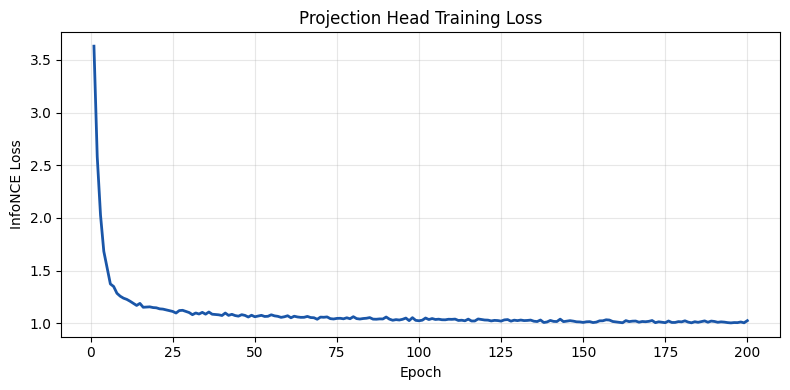

In [6]:
"""
STEP 3 — Train the MLP Projection Head (cross-modal alignment layer)
Colab-ready version (logic unchanged)
"""

import json
import numpy as np
from pathlib import Path
from collections import defaultdict
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import clip as openai_clip

# ─────────────────────────────────────────────
# 🔁 CHANGE THESE PATHS IF USING DRIVE
# ─────────────────────────────────────────────
METADATA_PATH      = Path("/content/app/kural_metadata.json")
RAW_EMBEDDINGS_PATH = Path("/content/kural_embeddings_raw.npy")
PROJECTION_PATH    = Path("/content/app/projection.pt")

# Example if using Drive:
# METADATA_PATH      = Path("/content/drive/MyDrive/kural_metadata.json")
# RAW_EMBEDDINGS_PATH = Path("/content/drive/MyDrive/kural_embeddings_raw.npy")
# PROJECTION_PATH    = Path("/content/drive/MyDrive/projection.pt")

# ─────────────────────────────────────────────
# Utility: simple logger
# ─────────────────────────────────────────────
class Log:
    @staticmethod
    def info(msg): print(f"[INFO] {msg}")
    @staticmethod
    def warning(msg): print(f"[WARN] {msg}")

log = Log()

# ─────────────────────────────────────────────
# Model definition (unchanged)
# ─────────────────────────────────────────────
class ProjectionHead(nn.Module):
    def __init__(self, in_dim: int, out_dim: int = 512, hidden_dim: int = 1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return nn.functional.normalize(self.net(x), dim=-1)

# ─────────────────────────────────────────────
# InfoNCE loss (unchanged)
# ─────────────────────────────────────────────
def info_nce_loss(img_emb: torch.Tensor, txt_emb: torch.Tensor, temperature: float = 0.07) -> torch.Tensor:
    logits = torch.matmul(img_emb, txt_emb.T) / temperature
    labels = torch.arange(len(img_emb), device=img_emb.device)
    loss_i2t = nn.functional.cross_entropy(logits, labels)
    loss_t2i = nn.functional.cross_entropy(logits.T, labels)
    return (loss_i2t + loss_t2i) / 2.0

# ─────────────────────────────────────────────
# Synthetic training pairs
# ─────────────────────────────────────────────
# Expanded Vision-to-Kural Scene Prompts (Sample of key sections across all 133 Chapters)
CHAPTER_SCENE_PROMPTS = {
    # --- ARATHUPPAL (VIRTUE) ---
    "கடவுள் வாழ்த்து": ["a person praying in a temple", "divine light shining", "meditating on a higher power"],
    "வான்சிறப்பு":     ["heavy rain falling on crops", "clouds gathering in the sky", "a flowing river"],
    "நீத்தார் பெருமை": ["a monk in saffron robes", "a sage sitting in silence", "renouncing worldly goods"],
    "அறன் வலியுறுத்தல்": ["a person doing a good deed", "virtuous behavior in public", "choosing the right path"],
    "இல்வாழ்க்கை":   ["a husband and wife at home", "a family sharing a meal", "domestic harmony"],
    "வாழ்க்கைத் துணைநலம்": ["a supportive wife helping her husband", "a woman managing a household", "marital partnership"],
    "மக்கட்பேறு":     ["a parent playing with their child", "a happy family together", "children laughing"],
    "அன்புடைமை":     ["a person hugging a loved one", "showing affection and care", "a couple holding hands"],
    "விருந்தோம்பல்":   ["welcoming guests into a home", "hosting a dinner party", "offering food to visitors"],
    "இனியவை கூறல்":  ["a person speaking kindly", "a warm smile during conversation", "gentle words of comfort"],
    "செய்ந்நன்றி அறிதல்": ["thanking someone who helped you", "returning a favor", "a person showing deep gratitude"],
    "நடுவுநிலைமை":    ["a fair judge in court", "balancing scales", "an unbiased person making a choice"],
    "அடக்கமுடைமை":   ["a person bowing humbly", "showing respect to elders", "controlling one's anger"],
    "ஒழுக்கமுடைமை":   ["a disciplined person", "following a strict code of conduct", "refined behavior"],
    "பிறனில் விழையாமை": ["avoiding temptation", "staying loyal to one's spouse", "moral boundaries"],
    "பொறையுடைமை":    ["a person staying calm under insult", "patiently waiting", "forgiving an enemy"],
    "அழுக்காறாமை":    ["looking at others' success without envy", "contentment with what one has"],
    "வெஃகாமை":       ["refusing to take what belongs to others", "not being greedy", "honesty in dealings"],
    "புறங்கூறாமை":    ["refusing to gossip", "speaking well of others behind their back", "silence in rumors"],
    "பயனில சொல்லாமை": ["avoiding useless talk", "speaking only what is necessary", "meaningful conversation"],
    "தீவினையச்சம்":   ["fear of doing something wrong", "a person hesitating to commit a crime"],
    "ஒப்புரவறிதல்":   ["helping the community", "a philanthropist giving back", "social duty"],
    "ஈகை":           ["giving money to a beggar", "donating clothes", "generosity to the poor"],
    "புகழ்":          ["a person being honored", "legacy and fame", "a statue of a great leader"],
    "அருளுடைமை":     ["showing compassion to animals", "mercy to the weak", "a kind-hearted person"],
    "புலால் மறுத்தல்": ["vegetarian food", "refusing to eat meat", "kindness to living beings"],
    "தவம்":           ["an ascetic meditating in the woods", "extreme self-discipline", "spiritual heat"],
    "கூடாவொழுக்கம்":   ["a hypocrite hiding their face", "false saintliness", "deceptive behavior"],
    "கள்ளாமை":       ["not stealing", "integrity in small things", "returning a lost wallet"],
    "வாய்மை":         ["a person telling the truth", "honest conversation", "swearing an oath"],
    "வெகுளாமை":       ["calming down from anger", "peaceful reaction to stress", "inner peace"],
    "இன்னா செய்யாமை": ["refusing to hurt someone who hurt you", "non-violence", "Ahimsa"],
    "கொல்லாமை":       ["saving an insect's life", "not killing", "protection of all life"],
    "நிலையாமை":       ["a sunset representing the end", "falling leaves", "impermanence of life"],
    "துறவு":           ["breaking chains", "letting go of attachments", "freedom from desire"],
    "மெய்ப்புணர்தல்":   ["realizing the truth", "clarity of mind", "enlightenment"],
    "அவாவறுத்தல்":     ["killing desire", "peace through minimalism", "no cravings"],
    "ஊழ்":             ["destiny and fate", "the turning wheel of time", "inevitable outcomes"],

    # --- PORUTPAL (WEALTH / POLITICS) ---
    "இறைமாட்சி":      ["a majestic king", "a great leader standing tall", "authority and grace"],
    "கல்வி":           ["a student studying hard", "books and learning", "a library setting"],
    "கல்லாமை":       ["an uneducated person", "the darkness of ignorance", "refusing to learn"],
    "கேள்வி":         ["listening to an elder", "attending a lecture", "learning by hearing"],
    "அறிவுடைமை":     ["a scholar reading", "wise decision making", "intellectual depth"],
    "குற்றங்கடிதல்":   ["self-correction", "fixing one's own mistakes", "removing flaws"],
    "பெரியாரைத் துணைக்கோடல்": ["seeking advice from a mentor", "walking with wise elders"],
    "சிற்றினம் சேராமை": ["avoiding bad company", "choosing good friends", "social boundaries"],
    "தெரிந்துசெயல்வகை": ["careful planning", "thinking before acting", "strategy board"],
    "தெரிந்து தெளிதல்": ["hiring the right person", "checking credentials", "trusting the worthy"],
    "தெரிந்து வினையாடல்": ["assigning tasks to experts", "delegation of work", "management"],
    "சுற்றந்தழால்":     ["a reunion of relatives", "embracing family members", "kinship"],
    "பொச்சாவாமை":     ["being alert", "avoiding forgetfulness", "sharp focus"],
    "செங்கோன்மை":      ["a fair scepter", "just governance", "a king listening to citizens"],
    "கொடுங்கோன்மை":    ["a tyrant king", "oppression of people", "cruel leadership"],
    "வெருவந்த செய்யாமை": ["not scaring subordinates", "gentle authority", "approachable leader"],
    "கண்ணோட்டம்":      ["looking with kindness", "consideration for others", "sympathetic gaze"],
    "ஒற்றாடல்":         ["a spy gathering information", "surveillance", "secret intelligence"],
    "ஊக்கமுடைமை":     ["inner drive", "high energy for work", "unshakable enthusiasm"],
    "மடியின்மை":       ["not being lazy", "getting up early", "active lifestyle"],
    "ஆள்வினையுடைமை":   ["persistent effort", "a person working hard despite failure", "tenacity"],
    "இடுக்கண் அழியாமை": ["smiling in the face of trouble", "courage in crisis", "not being depressed"],
    "அமைச்சு":         ["a minister advising", "political consultation", "statesmanship"],
    "சொல்வன்மை":      ["eloquent speech", "powerful oratory", "persuasive talking"],
    "வினைத்தூய்மை":     ["pure methods of working", "ethical business", "clean hands"],
    "வினைத்திட்பம்":     ["firmness in action", "resolute execution", "not giving up halfway"],
    "வினைசெயல்வகை":    ["different ways to finish a job", "efficient workflow", "tactics"],
    "தூது":           ["a diplomat traveling", "an ambassador speaking", "messengers"],
    "மன்னரைச் சேர்ந்தொழுதல்": ["behaving in front of leaders", "royal etiquette", "palace manners"],
    "குறிப்பறிதல்":      ["reading body language", "understanding unspoken words", "intuition"],
    "அவை அறிதல்":      ["understanding the audience", "speaking appropriately in public"],
    "அவை அஞ்சாமை":     ["public speaking confidence", "not being afraid of a crowd"],
    "நாடு":            ["a prosperous country", "fertile lands", "peaceful nation"],
    "அரண்":           ["a strong fortress", "defensive walls", "security and protection"],
    "பொருள்செயல்வகை":  ["earning money honestly", "wealth accumulation", "investment"],
    "படைமாட்சி":       ["a brave army", "disciplined soldiers", "military strength"],
    "படைச்செருக்கு":     ["heroic pride", "valiant warriors in battle", "courage of a soldier"],
    "நட்பு":           ["two friends laughing together", "loyalty and trust", "mutual support"],
    "நட்பாராய்தல்":      ["testing a friendship", "choosing friends carefully", "scrutiny"],
    "பழைமை":          ["long-term friendship", "comfort and familiarity", "old friends"],
    "தீநட்பு":         ["toxic friendship", "a friend who causes harm", "fake smile"],
    "கூடாநட்பு":       ["an enemy disguised as a friend", "betrayal", "treacherous alliance"],
    "பேதைமை":         ["foolishness", "ignorant behavior", "acting without thinking"],
    "புல்லறிவாண்மை":    ["shallow knowledge", "vanity of the half-learned", "stubbornness"],
    "இகழ்":           ["hostility and hatred", "conflict between people", "enmity"],
    "பகைமாட்சி":       ["strength of the enemy", "strategic opposition", "rivalry"],
    "பகைத்திறந்தெரிதல்": ["knowing the enemy's weakness", "analyzing opposition"],
    "உட்பகை":         ["a traitor within the group", "internal conflict", "hidden enemy"],
    "பெரியாரைப் பிழையாமை": ["not offending the powerful", "respecting greatness", "avoiding hubris"],
    "பெண்வழிச்சேறல்":    ["being overly influenced by a woman", "losing focus due to lust"],
    "வரைவின் மகளிர்":    ["women of the street", "unfaithful relationships", "lustful trap"],
    "கள்ளுண்ணாமை":     ["avoiding alcohol", "sobriety", "drunkenness and shame"],
    "சூது":           ["gambling with dice", "losing money in games", "addiction"],
    "மருந்து":         ["food as medicine", "a doctor treating a patient", "healthy eating"],
    "குடிமை":         ["noble birth and character", "dignity and family honor"],
    "மானம்":           ["self-respect", "choosing death over dishonor", "pride"],
    "பெருமை":         ["greatness of character", "humility in high position", "excellence"],
    "சான்றாண்மை":      ["perfect character", "a pillar of society", "balance of virtues"],
    "பண்புடைமை":       ["good manners", "being cultured and polite", "social grace"],
    "நன்றியில் செல்வம்": ["useless wealth", "a miser hoarding money", "rich but unhappy"],
    "நாணுடைமை":       ["shame in doing wrong", "modesty", "moral sensitivity"],
    "குடிசெயல்வகை":     ["uplifting one's family", "hard work for the lineage", "dedication"],
    "உழவு":           ["a farmer plowing", "agriculture", "foundation of the economy"],
    "நல்குரவு":         ["poverty", "a person struggling for food", "economic hardship"],
    "இரவு":           ["begging for help", "asking for charity", "dependency"],
    "இரவச்சம்":        ["dignity of not begging", "self-sufficiency", "hating dependency"],
    "கயமை":           ["lowly behavior", "mean-spirited people", "wickedness"],

    # --- KAMATHUPPAL (LOVE) ---
    "தகைணங்கணுறுத்தல்": ["falling in love at first sight", "beauty of the beloved"],
    "குறிப்பறிதல்(K)":  ["understanding signs of love", "glances between lovers"],
    "புணர்ச்சி மகிழ்தல்": ["joy of union", "lovers embracing", "happiness together"],
    "நலம் புனைந்துரைத்தல்": ["praising the beauty of the lover", "romantic poetry"],
    "காதற் சிறப்புரைத்தல்": ["the uniqueness of their love", "deep soul connection"],
    "நாணுத் துறவுரைத்தல்": ["losing modesty in love", "expressive passion"],
    "அலரறிவுறுத்தல்":    ["neighborhood gossip about lovers", "rumors in the village"],
    "பிரிவாற்றாமை":     ["pain of separation", "longing for the absent lover", "sadness"],
    "படர்மெலிந்திரங்கல்": ["pining away", "becoming thin from grief", "fading health due to love"],
    "கண்விதுப்பழிதல்":   ["eyes weeping for the lover", "looking at the path for their return"],
    "பசப்புறு பருவரல்":   ["the pallor of separation", "skin changing color due to grief"],
    "தனிப்படர் மிகுதி":    ["the intensity of loneliness", "suffering alone in the dark"],
    "நினைந்தவர் புலம்பல்": ["reminiscing about past moments", "talking to memories"],
    "கனவு நிலை உரைத்தல்": ["seeing the lover in a dream", "waking up to find them gone"],
    "பொழுதுகண்டு இரங்கல்": ["sadness at sunset", "evening bringing more pain"],
    "உறுப்புநலன் அழிதல்": ["fading beauty due to separation", "weary limbs"],
    "நெஞ்சொடு கிளத்தல்": ["talking to one's own heart", "internal romantic monologue"],
    "நிறையழிதல்":       ["losing self-control in love", "flooding emotions"],
    "அவர்வயின் விதும்பல்": ["desperate desire to meet", "impatience in love"],
    "குறிப்பறிவுறுத்தல்(P)": ["subtle hints between lovers", "silent communication"],
    "புணர்ச்சி விதுப்பல்": ["eagerness for the embrace", "passionate reunion"],
    "நெஞ்சொடு புலத்தல்": ["arguing with one's own heart", "conflicting feelings"],
    "புலவி":           ["a lover's tiff", "small misunderstanding", "pouting"],
    "புலவி நுணுக்கம்":   ["subtle feigned anger", "testing the lover's affection"],
    "ஊடலுவகை":       ["the joy of making up after a fight", "reconciliation"],
}

GENERIC_PROMPTS = [
    "a person helping a stranger",
    "people working together as a team",
    "someone making a difficult decision",
    "a peaceful scene in nature",
    "an act of kindness",
    "a person reflecting and thinking",
    "community and togetherness",
    "an elder sharing wisdom",
]

def build_training_pairs(kurals, kural_embeddings, clip_model, device):
    from torch import nn
    from collections import defaultdict
    log.info("Building synthetic training pairs…")

    chapter_to_indices = defaultdict(list)
    for i, k in enumerate(kurals):
        chapter_to_indices[k["chapter"]].append(i)

    pairs_img = []
    pairs_txt = []

    for chapter, indices in chapter_to_indices.items():
        matching_prompts = []
        for kw, prompts in CHAPTER_SCENE_PROMPTS.items():
            if kw in chapter or chapter in kw:
                matching_prompts.extend(prompts)
        if not matching_prompts:
            matching_prompts = GENERIC_PROMPTS[:3]

        with torch.no_grad():
            tokens = openai_clip.tokenize(matching_prompts[:5]).to(device)
            clip_text_feats = clip_model.encode_text(tokens).float()
            clip_text_feats = nn.functional.normalize(clip_text_feats, dim=-1)

        for clip_feat in clip_text_feats:
            for idx in indices:
                sarvam_feat = torch.tensor(kural_embeddings[idx], dtype=torch.float32)
                pairs_img.append(clip_feat.cpu())
                pairs_txt.append(sarvam_feat)

    with torch.no_grad():
        tokens = openai_clip.tokenize(GENERIC_PROMPTS).to(device)
        generic_feats = clip_model.encode_text(tokens).float()
        generic_feats = nn.functional.normalize(generic_feats, dim=-1)

    rng = np.random.default_rng(42)
    for clip_feat in generic_feats:
        for idx in rng.choice(len(kurals), size=10, replace=False):
            pairs_img.append(clip_feat.cpu())
            pairs_txt.append(torch.tensor(kural_embeddings[idx], dtype=torch.float32))

    log.info(f"Built {len(pairs_img)} training pairs from {len(chapter_to_indices)} chapters")
    return pairs_img, pairs_txt

# ─────────────────────────────────────────────
# Main training loop
# ─────────────────────────────────────────────
def main(epochs=200, lr=3e-4, batch_size=64):
    assert METADATA_PATH.exists(), f"Missing: {METADATA_PATH}"
    assert RAW_EMBEDDINGS_PATH.exists(), f"Missing: {RAW_EMBEDDINGS_PATH}"

    with open(METADATA_PATH, encoding="utf-8") as f:
        kurals = json.load(f)

    kural_embeddings = np.load(RAW_EMBEDDINGS_PATH)
    log.info(f"Loaded {len(kurals)} kurals, embeddings shape: {kural_embeddings.shape}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    log.info(f"Training on: {device}")

    log.info("Loading CLIP ViT-L/14…")
    clip_model, _ = openai_clip.load("ViT-L/14", device=device)
    clip_model.eval()
    log.info("CLIP loaded ✓")

    pairs_img, pairs_txt = build_training_pairs(kurals, kural_embeddings, clip_model, device)
    n_pairs = len(pairs_img)
    log.info(f"Total training pairs: {n_pairs}")

    img_feats = torch.stack(pairs_img).to(device)
    txt_feats = torch.stack(pairs_txt).to(device)

    img_proj = ProjectionHead(in_dim=768, out_dim=512).to(device)
    text_proj = ProjectionHead(in_dim=2048, out_dim=512).to(device)

    params = list(img_proj.parameters()) + list(text_proj.parameters())
    optimizer = AdamW(params, lr=lr, weight_decay=1e-2)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    log.info(f"Training for {epochs} epochs…")
    losses = []

    img_proj.train()
    text_proj.train()

    for epoch in range(1, epochs + 1):
        perm = torch.randperm(n_pairs, device=device)
        epoch_losses = []

        for i in range(0, n_pairs, batch_size):
            idx = perm[i : i + batch_size]
            if len(idx) < 2:
                continue

            img_batch = img_feats[idx]
            txt_batch = txt_feats[idx]

            img_emb = img_proj(img_batch)
            txt_emb = text_proj(txt_batch)

            loss = info_nce_loss(img_emb, txt_emb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            optimizer.step()

            epoch_losses.append(loss.item())

        scheduler.step()
        mean_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(mean_loss)

        if epoch % 10 == 0 or epoch == 1:
            log.info(f"Epoch {epoch:3d}/{epochs}  |  loss: {mean_loss:.4f}  |  lr: {scheduler.get_last_lr()[0]:.2e}")

    # Save weights
    PROJECTION_PATH.parent.mkdir(parents=True, exist_ok=True)
    torch.save({
        "img_proj":  img_proj.state_dict(),
        "text_proj": text_proj.state_dict(),
        "config": {
            "img_in_dim":  768,
            "txt_in_dim":  2048,
            "out_dim":     512,
            "hidden_dim":  1024,
        }
    }, PROJECTION_PATH)
    log.info(f"Saved → {PROJECTION_PATH} ({PROJECTION_PATH.stat().st_size / 1e6:.1f} MB)")

    # Save loss curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, epochs + 1), losses, color="#1A56A8", linewidth=2)
        plt.xlabel("Epoch"); plt.ylabel("InfoNCE Loss")
        plt.title("Projection Head Training Loss")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plot_path = PROJECTION_PATH.parent / "training_loss.png"
        plt.savefig(plot_path, dpi=150)
        log.info(f"Loss curve saved → {plot_path}")
    except Exception as e:
        log.warning(f"Could not save loss plot: {e}")

    log.info(f"Final loss: {losses[-1]:.4f}")
    log.info("Next step: python scripts/04_build_faiss.py")

# ─────────────────────────────────────────────
# Colab-friendly entry
# ─────────────────────────────────────────────
if __name__ == "__main__":
    # Direct call in Colab without argparse
    main(epochs=200, lr=3e-4, batch_size=64)

In [7]:
"""
STEP 4 — Build the FAISS vector index (Colab-ready)
==================================================

Input:
  - /content/app/kural_embeddings_raw.npy  (Step 2)
  - /content/app/projection.pt             (Step 3)
  - /content/app/kural_metadata.json       (Step 1)

Output:
  - /content/app/kural_index.faiss
  - /content/app/kural_embeddings_projected.npy
"""

import sys
import json
import numpy as np
from pathlib import Path

try:
    import torch
    import torch.nn as nn
    import faiss
except ImportError:
    !pip install faiss-cpu torch
    import torch
    import torch.nn as nn
    import faiss

APP_DIR = Path("/content/app")
RAW_EMB = Path("/content/kural_embeddings_raw.npy")      # <-- fix here
PROJ_PT  = APP_DIR / "projection.pt"
META_JSON= APP_DIR / "kural_metadata.json"
FAISS_IDX= APP_DIR / "kural_index.faiss"
PROJ_NPY = APP_DIR / "kural_embeddings_projected.npy"

# ── Logger replacement ──
def log_info(msg): print(f"[INFO] {msg}")
def log_warning(msg): print(f"[WARNING] {msg}")
def log_error(msg): print(f"[ERROR] {msg}")

def check_file(path: Path, name: str):
    if not path.exists():
        log_error(f"Missing file: {name} → {path}")
        sys.exit(1)

# ── Reuse same ProjectionHead architecture ──
class ProjectionHead(nn.Module):
    def __init__(self, in_dim: int, out_dim: int = 512, hidden_dim: int = 1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return nn.functional.normalize(self.net(x), dim=-1)

# ── Main ──
def main():
    check_file(RAW_EMB, "kural_embeddings_raw.npy (Step 2)")
    check_file(PROJ_PT, "projection.pt (Step 3)")
    check_file(META_JSON, "kural_metadata.json (Step 1)")

    # Load raw embeddings
    raw = np.load(RAW_EMB).astype(np.float32)  # (1330, 2048)
    log_info(f"Loaded raw embeddings: {raw.shape}")

    # Load trained projection head
    ckpt = torch.load(PROJ_PT, map_location="cpu")
    cfg = ckpt.get("config", {})
    txt_in_dim = cfg.get("txt_in_dim", 2048)
    out_dim    = cfg.get("out_dim", 512)
    hidden_dim = cfg.get("hidden_dim", 1024)

    text_proj = ProjectionHead(in_dim=txt_in_dim, out_dim=out_dim, hidden_dim=hidden_dim)
    text_proj.load_state_dict(ckpt["text_proj"])
    text_proj.eval()
    log_info(f"Loaded text projector: {txt_in_dim} → {out_dim}")

    # Project embeddings
    with torch.no_grad():
        tensor = torch.tensor(raw)
        projected = text_proj(tensor).numpy()  # (1330, 512)

    log_info(f"Projected embeddings: {projected.shape}")

    # L2-normalise for cosine similarity
    faiss.normalize_L2(projected)

    # Verify no NaN/Inf
    if not np.isfinite(projected).all():
        bad = (~np.isfinite(projected)).sum()
        log_error(f"{bad} non-finite values after projection")
        sys.exit(1)

    # Build FAISS index
    dimension = projected.shape[1]  # 512
    index = faiss.IndexFlatIP(dimension)
    index.add(projected)
    log_info(f"FAISS index: {index.ntotal} vectors, dimension {dimension}")

    # Sanity check
    query = projected[0:1].copy()
    scores, indices = index.search(query, k=5)
    log_info(f"Sanity check: top-5 neighbours of Kural #0: indices={indices[0]}, scores={scores[0].round(3)}")
    if indices[0][0] != 0:
        log_warning("Top-1 result is not self — this is unusual but may be OK.")

    # Save index and projected embeddings
    faiss.write_index(index, str(FAISS_IDX))
    size_kb = FAISS_IDX.stat().st_size // 1024
    log_info(f"Saved → {FAISS_IDX} ({size_kb} KB)")

    np.save(PROJ_NPY, projected)
    log_info(f"Saved projected embeddings → {PROJ_NPY}")

    # Quick retrieval tests
    with open(META_JSON, encoding="utf-8") as f:
        kurals = json.load(f)

    log_info("Quick retrieval tests:")
    for test_idx in [0, 62, 296, 1294]:
        if test_idx < len(kurals):
            q = projected[test_idx:test_idx+1].copy()
            _, top = index.search(q, k=3)
            names = [f"#{kurals[i]['number']}" for i in top[0]]
            log_info(f"  Kural #{kurals[test_idx]['number']} → top-3: {', '.join(names)}")

    log_info("FAISS index ready for retrieval!")

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 45.7 MB/s eta 0:00:00
[INFO] Loaded raw embeddings: (1330, 2048)
[INFO] Loaded text projector: 2048 → 512
[INFO] Projected embeddings: (1330, 512)
[INFO] FAISS index: 1330 vectors, dimension 512
[INFO] Sanity check: top-5 neighbours of Kural #0: indices=[  0 183 533 890 538], scores=[1.    0.895 0.876 0.857 0.849]
[INFO] Saved → /content/app/kural_index.faiss (2660 KB)
[INFO] Saved projected embeddings → /content/app/kural_embeddings_projected.npy
[INFO] Quick retrieval tests:
[INFO]   Kural #409 → top-3: #409, #408, #410
[INFO]   Kural #561 → top-3: #561, #562, #568
[INFO]   Kural #312 → top-3: #312, #318, #313
[INFO]   Kural #328 → top-3: #328, #322, #327
[INFO] FAISS index ready for retrieval!


In [9]:
# ── Step 5: Evaluate retrieval quality (Colab-ready) ──
import sys
import json
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import faiss
import clip as openai_clip
from PIL import Image

# ── Colab paths ──
APP_DIR    = Path("/content/app")
FAISS_IDX  = APP_DIR / "kural_index.faiss"
PROJ_PT    = APP_DIR / "projection.pt"
META_JSON  = APP_DIR / "kural_metadata.json"

# ── Logging ──
class log:
    @staticmethod
    def info(msg): print(f"[INFO] {msg}")
    @staticmethod
    def warning(msg): print(f"[WARNING] {msg}")
    @staticmethod
    def error(msg): print(f"[ERROR] {msg}")

def check_file(path: Path, name: str):
    if not path.exists():
        log.error(f"Missing file: {name} → {path}")
        sys.exit(1)

# ── Projection Head ──
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=512, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        return nn.functional.normalize(self.net(x), dim=-1)

# ── Test cases ──
TEST_CASES = [
    ("a parent lovingly watching their child play",          "Virtue", "மக்கட்"),
    ("two friends laughing and helping each other",          "Virtue", "நட்பு"),
    ("a person telling the truth to a judge",                "Virtue", "வாய்மை"),
    ("a disciplined person studying books diligently",       "Virtue", "கல்வி"),
    ("a ruler making fair judgements for the people",        "Wealth", "நல்லாட்"),
    ("a hardworking farmer tilling the fields",              "Wealth", "வேளாண்"),
    ("two people in love gazing at each other",              "Love",   "காமம்"),
    ("a person crying alone missing their loved one",        "Love",   "பிரிவு"),
    ("sharing a meal with guests at home",                   "Virtue", "விருந்து"),
    ("a person meditating and renouncing worldly desires",   "Virtue", "துறவு"),
    ("a king rewarding a loyal minister",                    "Wealth", "அமைச்"),
    ("a woman longing for her absent husband",               "Love",   "பெண்"),
    ("a person who never gives up despite hardship",         "Virtue", "மடி"),
    ("gratitude shown to someone who helped in need",        "Virtue", "செய்நன்றி"),
    ("speaking kind and gentle words to others",             "Virtue", "இன்சொல்"),
]

# ── Metrics computation ──
def compute_metrics(results):
    pal_hit_k = {1:0, 3:0, 5:0}
    chapter_hit_k = {1:0, 3:0, 5:0}
    for r in results:
        expected_pal = r["expected_pal"]
        expected_kw  = r["expected_chapter_kw"]
        retrieved    = r["retrieved"]
        for k in [1,3,5]:
            top_k = retrieved[:k]
            pals    = [x["pal"] for x in top_k]
            chapters= [x["chapter"] for x in top_k]
            if expected_pal in pals:
                pal_hit_k[k] += 1
            if any(expected_kw in ch for ch in chapters):
                chapter_hit_k[k] += 1
    n = len(results)
    return {
        "n_queries": n,
        "pal_hit@1": pal_hit_k[1]/n,
        "pal_hit@3": pal_hit_k[3]/n,
        "pal_hit@5": pal_hit_k[5]/n,
        "chapter_hit@1": chapter_hit_k[1]/n,
        "chapter_hit@3": chapter_hit_k[3]/n,
        "chapter_hit@5": chapter_hit_k[5]/n,
    }

# ── Main evaluation ──
def main(image_dir: str | None = None):
    for p, name in zip([FAISS_IDX, PROJ_PT, META_JSON],
                       ["faiss_index", "projection.pt", "metadata"]):
        check_file(p, name)

    with open(META_JSON, encoding="utf-8") as f:
        kurals = json.load(f)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    log.info("Loading CLIP ViT-L/14…")
    clip_model, clip_preprocess = openai_clip.load("ViT-L/14", device=device)
    clip_model.eval()

    # Load projection head
    ckpt = torch.load(PROJ_PT, map_location="cpu")
    cfg = ckpt.get("config", {})
    img_proj = ProjectionHead(in_dim=cfg.get("img_in_dim", 768), out_dim=cfg.get("out_dim", 512))
    img_proj.load_state_dict(ckpt["img_proj"])
    img_proj.eval()
    img_proj = img_proj.to(device)

    # Load FAISS index
    index = faiss.read_index(str(FAISS_IDX))
    log.info(f"FAISS index loaded: {index.ntotal} vectors")

    # ── Retrieval functions ──
    def retrieve(query_vec: np.ndarray, k: int = 5):
        faiss.normalize_L2(query_vec)
        scores, indices = index.search(query_vec, k=k)
        results = []
        for score, idx in zip(scores[0], indices[0]):
            k_data = kurals[idx].copy()
            k_data["score"] = float(score)
            results.append(k_data)
        return results

    def encode_text(text: str):
        tokens = openai_clip.tokenize([text]).to(device)
        with torch.no_grad():
            clip_feat = clip_model.encode_text(tokens).float()
            projected = img_proj(clip_feat)
        return projected.cpu().numpy().astype("float32")

    # ── TEXT EVALUATION ──
    log.info("="*60)
    log.info("TEXT-TO-KURAL EVALUATION")
    log.info("="*60)

    all_results = []
    for query, expected_pal, expected_kw in TEST_CASES:
        query_vec = encode_text(query)
        retrieved = retrieve(query_vec, k=5)
        result = {
            "query": query,
            "expected_pal": expected_pal,
            "expected_chapter_kw": expected_kw,
            "retrieved": retrieved,
        }
        all_results.append(result)
        print(f"\nQuery: \"{query}\"")
        print(f"Expected: {expected_pal} / chapter contains '{expected_kw}'")
        for i, r in enumerate(retrieved[:3], 1):
            match_pal = "✓" if r["pal"] == expected_pal else "✗"
            match_ch  = "✓" if expected_kw in r["chapter"] else " "
            print(f"  {i}. [Pal:{match_pal} Ch:{match_ch}] #{r['number']:4d} {r['chapter']:15s} "
                  f"| score={r['score']:.3f} | {r['kural_tamil'][:35]}…")

    # ── Metrics ──
    metrics = compute_metrics(all_results)
    print("\n" + "="*60)
    print("METRICS SUMMARY")
    print("="*60)
    for k,v in metrics.items():
        if k!="n_queries":
            print(f"  {k:18s}: {v:.1%}")
    print("="*60)

    # ── IMAGE EVALUATION (optional) ──
    if image_dir:
        image_path = Path(image_dir)
        image_files = list(image_path.glob("*.jpg")) + list(image_path.glob("*.png"))
        if not image_files:
            log.warning(f"No images found in {image_dir}")
        else:
            log.info(f"\nIMAGE EVALUATION ({len(image_files)} images)")
            for img_path in image_files[:10]:
                img = Image.open(img_path).convert("RGB")
                tensor = clip_preprocess(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    clip_feat = clip_model.encode_image(tensor).float()
                    projected = img_proj(clip_feat)
                query_vec = projected.cpu().numpy().astype("float32")
                retrieved = retrieve(query_vec, k=3)
                print(f"\nImage: {img_path.name}")
                for i, r in enumerate(retrieved, 1):
                    print(f"  {i}. #{r['number']:4d} [{r['pal']:7s}] {r['chapter']:20s} score={r['score']:.3f}")
                    print(f"     {r['kural_tamil']}")
                    print(f"     {r['explanation'][:80]}…")

    # ── Save results ──
    out_file = APP_DIR.parent / "evaluation_results.json"
    with open(out_file, "w", encoding="utf-8") as f:
        json.dump({"metrics": metrics, "results": all_results}, f, ensure_ascii=False, indent=2)
    log.info(f"Detailed results saved → {out_file}")

# ── Run in Colab ──
main(image_dir=None)      # uncomment and run if you want image evaluation too

[INFO] Loading CLIP ViT-L/14…
[INFO] FAISS index loaded: 1330 vectors
[INFO] ============================================================
[INFO] TEXT-TO-KURAL EVALUATION
[INFO] ============================================================

Query: "a parent lovingly watching their child play"
Expected: Virtue / chapter contains 'மக்கட்'
  1. [Pal:✓ Ch:✓] #  62 மக்கட்பேறு      | score=0.756 | எழுபிறப்பும் தீயவை தீண்டா பழிபிறங்க…
  2. [Pal:✓ Ch:✓] #  66 மக்கட்பேறு      | score=0.717 | குழல் இனிது யாழ்இனிது என்பதம் மக்கள…
  3. [Pal:✓ Ch:✓] #  67 மக்கட்பேறு      | score=0.713 | தந்தை மகற்காற்று நன்றி அவையத்து முந…

Query: "two friends laughing and helping each other"
Expected: Virtue / chapter contains 'நட்பு'
  1. [Pal:✗ Ch:✓] # 829 கூடா நட்பு      | score=0.705 | மிகச்செய்து தம்மெள்ளு வாரை நகச்செய்…
  2. [Pal:✗ Ch:✓] # 824 கூடா நட்பு      | score=0.673 | முகத்தின் இனிய நகாஅ அகத்தின்னா வஞ்ச…
  3. [Pal:✗ Ch:✓] # 818 தீ நட்பு        | score=0.672 | ஒல்லும் கருமம் உடற்று பவர்கேண்மை சொ…

Query: